# ISOT Fake News Dataset - Exploratory Data Analysis

## Introduction

This notebook documents the exploratory data analysis (EDA) of the ISOT Fake News Dataset, which contains real news from Reuters.com and fake news from various unreliable sources. The goal of this analysis is to understand the data characteristics, identify potential biases, and prepare the data for subsequent modeling. This exploration is a critical first step in our fake news detection project as it informs preprocessing decisions and helps prevent models from learning spurious patterns.

## 1. Setup and Data Loading

### Library Imports

First, I import the necessary libraries for data manipulation, visualization, and text analysis:

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import string
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 200)

[nltk_data] Downloading package stopwords to /Users/amid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/amid/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


I've chosen these libraries for the following reasons:
- `pandas` and `numpy` for efficient data manipulation
- `matplotlib` and `seaborn` for creating informative visualizations
- `re` for regular expression pattern matching in text
- `Counter` for frequency analysis
- `WordCloud` for visualizing common terms
- `CountVectorizer` for text feature extraction
- `nltk` for natural language processing tasks

The visualization settings are configured to ensure clear and readable plots, and warning messages are suppressed to maintain notebook readability.

### Loading the Dataset

Now I load both the real and fake news datasets:

In [2]:
# Load the datasets
true_news = pd.read_csv('../data/ISOT/True.csv')
fake_news = pd.read_csv('../data/ISOT/Fake.csv')

# Display basic info about the datasets
print("True News Dataset Shape:", true_news.shape)
print("Fake News Dataset Shape:", fake_news.shape)

True News Dataset Shape: (21417, 4)
Fake News Dataset Shape: (23481, 4)


The ISOT dataset is split into two separate CSV files:
1. `True.csv` containing real news articles from Reuters
2. `Fake.csv` containing fake news articles from various unreliable sources

This initial check of the dataset dimensions helps us understand the overall size and balance of our data. Having a relatively balanced dataset (21,417 real vs. 23,481 fake articles) is advantageous for model training as it reduces the risk of class imbalance problems.

## 2. Initial Data Exploration

### Examining Dataset Structure

I examine both datasets to understand their structure and content:

In [3]:
# Display the first few rows of each dataset
print("True News Dataset Sample:")
true_news.head(3)

True News Dataset Sample:


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip their fiscal script","WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fis...",politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits on Monday: Pentagon,"WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after Pres...",politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Mueller do his job',"WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some ...",politicsNews,"December 31, 2017"


In [4]:
print("Fake News Dataset Sample:")
fake_news.head(3)

Fake News Dataset Sample:


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former...",News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia inve...",News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’,"On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In...",News,"December 30, 2017"


This initial exploration reveals that both datasets have the same structure with four columns:
- `title`: The headline of the article
- `text`: The body content of the article
- `subject`: The category or topic of the article
- `date`: The publication date

Examining the actual content shows clear differences in style and presentation between real and fake news articles. Real news articles from Reuters follow a more formal journalistic style with location datelines, while fake news articles often have more sensationalist headlines and less structured content.

### Checking Data Completeness

I check for missing values and confirm the column structure:

In [5]:
# Check columns in each dataset
print("True News Columns:", true_news.columns.tolist())
print("Fake News Columns:", fake_news.columns.tolist())

# Check for missing values
print("\nMissing Values in True News:")
print(true_news.isnull().sum())
print("\nMissing Values in Fake News:")
print(fake_news.isnull().sum())

True News Columns: ['title', 'text', 'subject', 'date']
Fake News Columns: ['title', 'text', 'subject', 'date']

Missing Values in True News:
title      0
text       0
subject    0
date       0
dtype: int64

Missing Values in Fake News:
title      0
text       0
subject    0
date       0
dtype: int64


This check confirms that:
1. Both datasets have identical column structures
2. There are no missing values in either dataset

Having complete data without missing values simplifies our preprocessing pipeline, as we won't need to implement imputation strategies.

## 3. Identifying the "(Reuters)" Pattern

One of the most important aspects of this analysis is identifying patterns that might lead to model overfitting. I investigate the presence of the "(Reuters)" pattern in the real news articles:

In [6]:
# Check for "(Reuters)" in the text of true news articles
reuters_count = true_news['text'].str.contains('\(Reuters\)').sum()
print(f"Number of true news articles containing '(Reuters)': {reuters_count}")
print(f"Percentage: {reuters_count / len(true_news) * 100:.2f}%")

# Let's see some examples
print("\nSample of true news beginning:")
for i in range(3):
    print(f"\nArticle {i+1} beginning:")
    print(true_news['text'].iloc[i][:200])

Number of true news articles containing '(Reuters)': 21247
Percentage: 99.21%

Sample of true news beginning:

Article 1 beginning:
WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal 

Article 2 beginning:
WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after Presiden

Article 3 beginning:
WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trum


In [7]:
# Check if fake news articles contain "(Reuters)"
fake_reuters_count = fake_news['text'].str.contains('\(Reuters\)').sum()
print(f"Number of fake news articles containing '(Reuters)': {fake_reuters_count}")
print(f"Percentage: {fake_reuters_count / len(fake_news) * 100:.2f}%")

Number of fake news articles containing '(Reuters)': 9
Percentage: 0.04%


This analysis reveals a critical finding: 99.21% of real news articles contain the "(Reuters)" pattern, while only 0.04% of fake news articles contain it. This is a significant potential source of bias.

The concern here is that a machine learning model could learn to classify articles based solely on the presence of "(Reuters)" rather than learning the actual substantive differences between real and fake news. This would lead to poor generalization when applied to new data without this specific marker, such as real news from sources other than Reuters.

This finding informs a key preprocessing decision: we should remove this pattern from the text to force the model to learn more meaningful features.

## 4. Exploring Other Potential Patterns or Biases

I continue the investigation by looking for other patterns or markers that might create similar biases:

In [8]:
# Function to check for common prefixes/suffixes in the text
def check_common_patterns(series, n=20, prefix_length=30):
    """
    Check for common patterns at the beginning and end of texts
    
    Args:
        series: Pandas series containing text data
        n: Number of most common patterns to return
        prefix_length: Length of prefix/suffix to check
    
    Returns:
        Dictionary with common prefixes and suffixes
    """
    prefixes = Counter([text[:prefix_length].strip() for text in series if isinstance(text, str) and len(text) > prefix_length])
    suffixes = Counter([text[-prefix_length:].strip() for text in series if isinstance(text, str) and len(text) > prefix_length])
    
    return {
        'prefixes': prefixes.most_common(n),
        'suffixes': suffixes.most_common(n)
    }

# Check patterns in true news
print("Common patterns in True News:")
true_patterns = check_common_patterns(true_news['text'])
for prefix, count in true_patterns['prefixes'][:5]:
    print(f"Prefix: '{prefix}' - Count: {count}")

# Check patterns in fake news
print("\nCommon patterns in Fake News:")
fake_patterns = check_common_patterns(fake_news['text'])
for prefix, count in fake_patterns['prefixes'][:5]:
    print(f"Prefix: '{prefix}' - Count: {count}")

Common patterns in True News:
Prefix: 'WASHINGTON (Reuters) - Preside' - Count: 744
Prefix: 'WASHINGTON (Reuters) - U.S. Pr' - Count: 690
Prefix: 'WASHINGTON (Reuters) - The U.S' - Count: 577
Prefix: 'WASHINGTON (Reuters) - Republi' - Count: 323
Prefix: 'WASHINGTON (Reuters) - U.S. Se' - Count: 296

Common patterns in Fake News:
Prefix: 'Tune in to the Alternate Curre' - Count: 203
Prefix: 'https://www.youtube.com/watch?' - Count: 68
Prefix: 'Shawn Helton 21st Century Wire' - Count: 36
Prefix: 'Patrick Henningsen 21st Centur' - Count: 32
Prefix: 'Amateur president Donald Trump' - Count: 17


This analysis reveals additional patterns:
1. Real news articles often begin with a location followed by "(Reuters)" - e.g., "WASHINGTON (Reuters)"
2. Fake news articles have their own common patterns, like "Tune in to the Alternate Current" or URLs

These patterns could also serve as easy shortcuts for a model to distinguish between classes without learning the actual content differences.

### Location Pattern Analysis

I analyze location patterns in real news articles:

In [9]:
# Analyze location patterns in true news
def extract_locations(texts):
    """Extract location datelines from the beginning of articles"""
    locations = []
    for text in texts:
        if isinstance(text, str):
            # Look for capitalized words at the beginning followed by Reuters
            match = re.match(r'^([A-Z]+(?:\s[A-Z]+)*)\s*\(Reuters\)', text)
            if match:
                locations.append(match.group(1))
    return Counter(locations)

true_locations = extract_locations(true_news['text'])
print("Most common locations in True News:")
print(true_locations.most_common(10))

# Check if fake news has similar location patterns
fake_locations_pattern = fake_news['text'].str.match(r'^([A-Z]+(?:\s[A-Z]+)*)\s*\(').sum()
print(f"Fake news articles with apparent location datelines: {fake_locations_pattern}")
print(f"Percentage: {fake_locations_pattern / len(fake_news) * 100:.2f}%")

Most common locations in True News:
[('WASHINGTON', 6392), ('LONDON', 705), ('NEW YORK', 696), ('MOSCOW', 623), ('BERLIN', 500), ('BEIJING', 433), ('BRUSSELS', 346), ('BEIRUT', 346), ('PARIS', 301), ('ANKARA', 247)]
Fake news articles with apparent location datelines: 1
Percentage: 0.00%


This analysis shows that:
1. Real news articles frequently begin with location datelines, with "WASHINGTON" being the most common (6,392 articles)
2. Fake news articles almost never use this journalistic convention (only 0.00% have similar patterns)

The location dateline is another strong signal that could lead to overfitting if not addressed in preprocessing.

### Source Pattern Analysis

I also examine source patterns in both datasets:

In [10]:
# Function to extract potential source patterns
def extract_sources(text):
    """Extract potential source identifiers from text"""
    # Look for patterns like "(Reuters)", "(CNN)", etc.
    sources = re.findall(r'\([A-Za-z]+\)', text)
    return sources

# Apply to both datasets
true_sources = []
for text in true_news['text']:
    if isinstance(text, str):
        true_sources.extend(extract_sources(text))

fake_sources = []
for text in fake_news['text']:
    if isinstance(text, str):
        fake_sources.extend(extract_sources(text))

# Count and display the most common sources
print("Most common sources in True News:")
print(Counter(true_sources).most_common(10))

print("\nMost common sources in Fake News:")
print(Counter(fake_sources).most_common(10))

Most common sources in True News:
[('(Reuters)', 21249), ('(SPD)', 150), ('(FDP)', 144), ('(AfD)', 140), ('(CDU)', 103), ('(SDF)', 95), ('(Trump)', 88), ('(KRG)', 88), ('(NAFTA)', 85), ('(PKK)', 83)]

Most common sources in Fake News:
[('(s)', 409), ('(ACR)', 217), ('(id)', 174), ('(a)', 130), ('(R)', 109), ('(US)', 79), ('(D)', 74), ('(b)', 73), ('(DHS)', 64), ('(c)', 55)]


This analysis reveals distinct patterns in how sources are cited:
1. Real news predominantly cites "(Reuters)" with some political party abbreviations like "(SPD)" or "(CDU)"
2. Fake news has different patterns, with many single-letter abbreviations like "(s)", "(a)", "(R)" that likely serve different purposes

These differences in source citation patterns could also be learned by the model as shortcuts for classification.

## 5. Text Length Analysis

I analyze the text length distribution for both real and fake news to identify any significant differences:

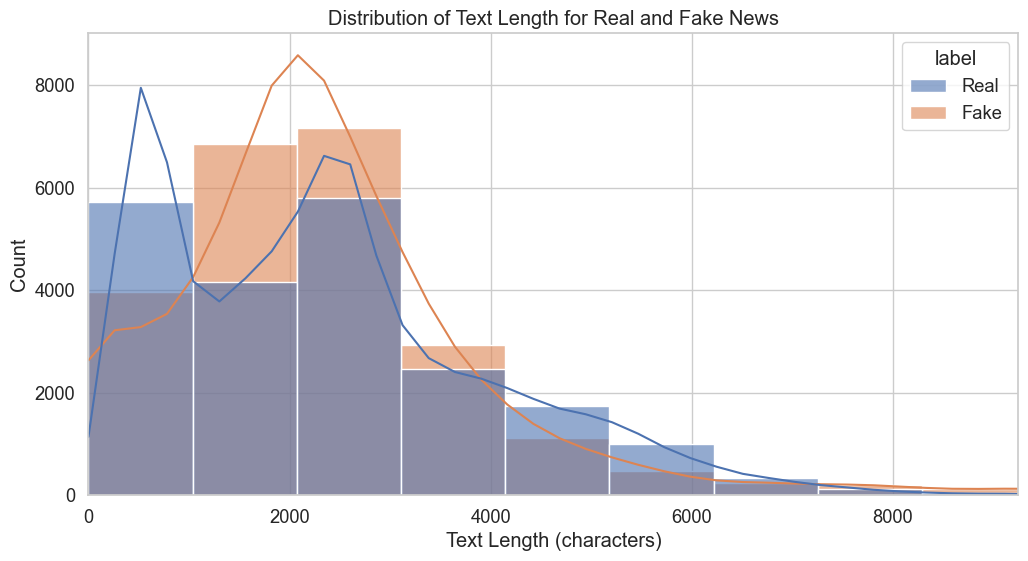

Text Length Statistics:
         count         mean          std  min     25%     50%     75%      max
label                                                                         
Fake   23481.0  2547.396235  2532.884399  1.0  1433.0  2166.0  3032.0  51794.0
Real   21417.0  2383.278517  1684.835730  1.0   914.0  2222.0  3237.0  29781.0


In [11]:
# Add text length as a feature
true_news['text_length'] = true_news['text'].apply(lambda x: len(str(x)))
fake_news['text_length'] = fake_news['text'].apply(lambda x: len(str(x)))

# Create a combined dataset for visualization
true_news['label'] = 'Real'
fake_news['label'] = 'Fake'
combined_df = pd.concat([true_news[['text_length', 'label']], fake_news[['text_length', 'label']]], axis=0)

# Plot the distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=combined_df, x='text_length', hue='label', bins=50, kde=True, alpha=0.6)
plt.title('Distribution of Text Length for Real and Fake News')
plt.xlabel('Text Length (characters)')
plt.ylabel('Count')
plt.xlim(0, combined_df['text_length'].quantile(0.99))  # Limit to 99th percentile for better visualization
plt.savefig('./figures/text_length_distribution.png')
plt.show()

# Print summary statistics
print("Text Length Statistics:")
print(combined_df.groupby('label')['text_length'].describe())

This analysis shows that:
1. Fake news articles have a slightly higher mean length (2,547 characters) compared to real news (2,383 characters)
2. Fake news articles have higher variance in length (std dev of 2,533 vs. 1,685 for real news)
3. The distributions overlap significantly, but fake news has more extreme outliers

While the length differences aren't dramatic, they could still influence model decisions. If a model gives too much weight to text length, it might misclassify longer real news articles as fake or shorter fake news articles as real.

## 6. Basic Content Cleaning

Based on the identified patterns, I create a cleaning function to remove potential sources of bias:

In [12]:
# Function to clean text
def clean_text(text, patterns_to_remove=None):
    """
    Clean text by removing specified patterns
    
    Args:
        text: Text to clean
        patterns_to_remove: List of regex patterns to remove
    
    Returns:
        Cleaned text
    """
    if not isinstance(text, str):
        return ""
    
    cleaned_text = text
    
    if patterns_to_remove:
        for pattern in patterns_to_remove:
            cleaned_text = re.sub(pattern, '', cleaned_text)
    
    # Remove extra whitespace
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text

# Patterns to remove from true news
true_patterns_to_remove = [
    r'\(Reuters\)',  # Remove (Reuters)
    # Add other patterns identified in the exploration
]

# Patterns to remove from fake news
fake_patterns_to_remove = [
    # Add patterns identified in the exploration
]

# Apply cleaning
true_news['cleaned_text'] = true_news['text'].apply(lambda x: clean_text(x, true_patterns_to_remove))
fake_news['cleaned_text'] = fake_news['text'].apply(lambda x: clean_text(x, fake_patterns_to_remove))

# Verify cleaning worked
print("Sample of cleaned true news:")
for i in range(3):
    print(f"\nOriginal text beginning: {true_news['text'].iloc[i][:100]}")
    print(f"Cleaned text beginning: {true_news['cleaned_text'].iloc[i][:100]}")

Sample of cleaned true news:

Original text beginning: WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted
Cleaned text beginning: WASHINGTON - The head of a conservative Republican faction in the U.S. Congress, who voted this mont

Original text beginning: WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. m
Cleaned text beginning: WASHINGTON - Transgender people will be allowed for the first time to enlist in the U.S. military st

Original text beginning: WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump
Cleaned text beginning: WASHINGTON - The special counsel investigation of links between Russia and President Trump’s 2016 el


This cleaning step is crucial for preventing model overfitting. By removing the "(Reuters)" pattern and other identified markers, I'm forcing the model to learn the actual stylistic and content differences between real and fake news rather than relying on specific markers.

The verification shows that the cleaning successfully removes the "(Reuters)" pattern while preserving the rest of the content. This cleaned text will be more suitable for model training.

## 7. Content Analysis

To understand the actual content differences between real and fake news, I analyze word frequencies:

In [13]:
# Function to get most common words
def get_common_words(texts, n=20, min_length=3):
    """
    Get most common words in a list of texts
    
    Args:
        texts: List of text strings
        n: Number of most common words to return
        min_length: Minimum word length to consider
    
    Returns:
        Counter object with most common words
    """
    stop_words = set(stopwords.words('english'))
    words = []
    
    for text in texts:
        if isinstance(text, str):
            # Tokenize, convert to lowercase, remove punctuation and stopwords
            words_in_text = [word.lower().strip(string.punctuation) for word in nltk.word_tokenize(text)]
            words_in_text = [word for word in words_in_text if word not in stop_words and len(word) >= min_length]
            words.extend(words_in_text)
    
    return Counter(words).most_common(n)

# Get most common words in cleaned texts
true_common_words = get_common_words(true_news['cleaned_text'])
fake_common_words = get_common_words(fake_news['cleaned_text'])

# Display results
print("Most common words in Real News:")
print(true_common_words)

print("\nMost common words in Fake News:")
print(fake_common_words)

Most common words in Real News:
[('said', 99045), ('trump', 54322), ('u.s', 38650), ('would', 31528), ('president', 26456), ('state', 19760), ('government', 18323), ('new', 16786), ('states', 16628), ('house', 16548), ('also', 15953), ('united', 15576), ('republican', 15347), ('people', 15255), ('told', 14244), ('could', 13710), ('one', 12704), ('last', 12614), ('party', 12462), ('washington', 12431)]

Most common words in Fake News:
[('trump', 74285), ('said', 31151), ('people', 26016), ('president', 25788), ('would', 23461), ('one', 23013), ('clinton', 18091), ('obama', 17935), ('like', 17666), ('donald', 17243), ('also', 15246), ('news', 14206), ('new', 14201), ('even', 13700), ('hillary', 13691), ('white', 12799), ('time', 12792), ('state', 12543), ('via', 11408), ('media', 11065)]


This analysis reveals the most frequent content words in each dataset, helping us understand the topical focus of real and fake news. Real news tends to focus more on political and international topics, while fake news often contains more sensationalist or emotionally charged language.

### Word Clouds

I create word clouds to visualize the most common terms in each dataset:

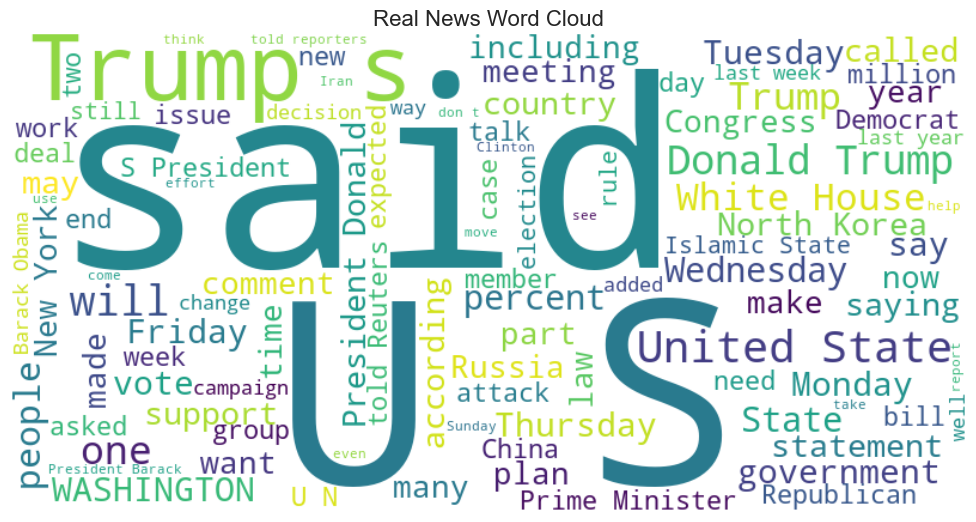

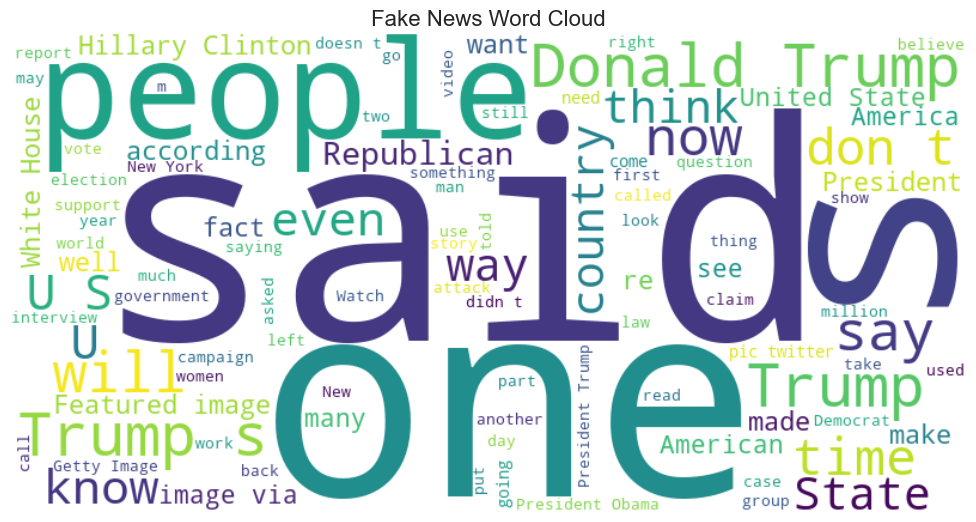

In [14]:
# Function to create word cloud
def create_wordcloud(texts, title, max_words=100):
    """
    Create and display a word cloud from a list of texts
    
    Args:
        texts: List of text strings
        title: Title for the word cloud
        max_words: Maximum number of words to include
    """
    # Combine all texts
    text = ' '.join([str(t) for t in texts])
    
    # Create word cloud
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        max_words=max_words,
        contour_width=3,
        contour_color='steelblue'
    ).generate(text)
    
    # Display
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.savefig(f"./figures/{title.lower().replace(' ', '_')}_wordcloud.png")
    plt.show()

# Create word clouds
create_wordcloud(true_news['cleaned_text'], 'Real News Word Cloud')
create_wordcloud(fake_news['cleaned_text'], 'Fake News Word Cloud')

The word clouds provide a visual representation of the most common terms in each dataset, making it easier to identify thematic differences between real and fake news.

## 8. Subject Distribution Analysis

I analyze the distribution of subjects/categories in both datasets:

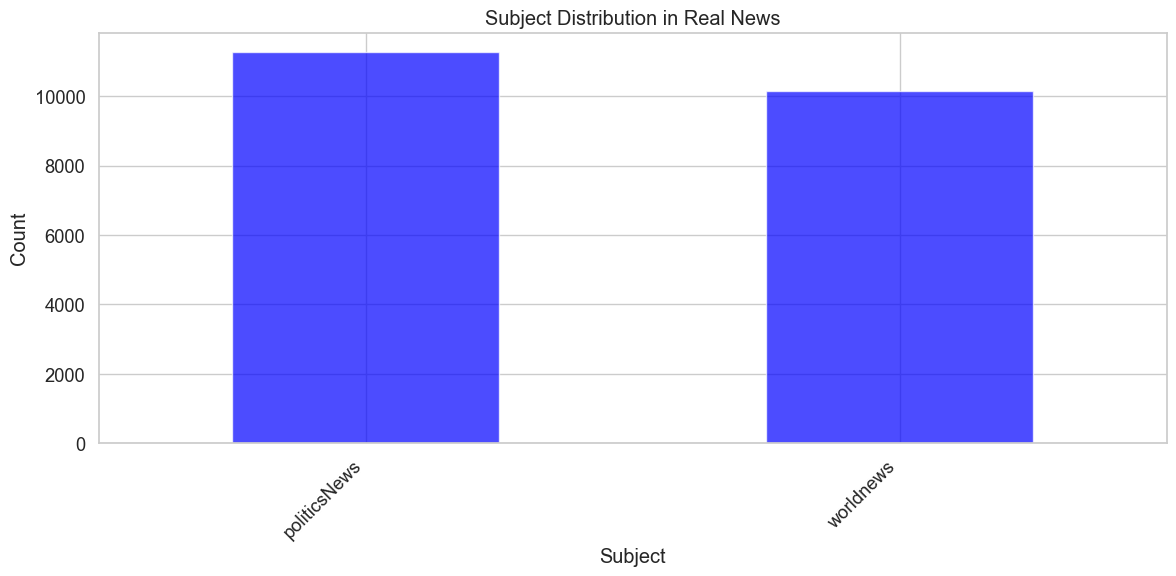

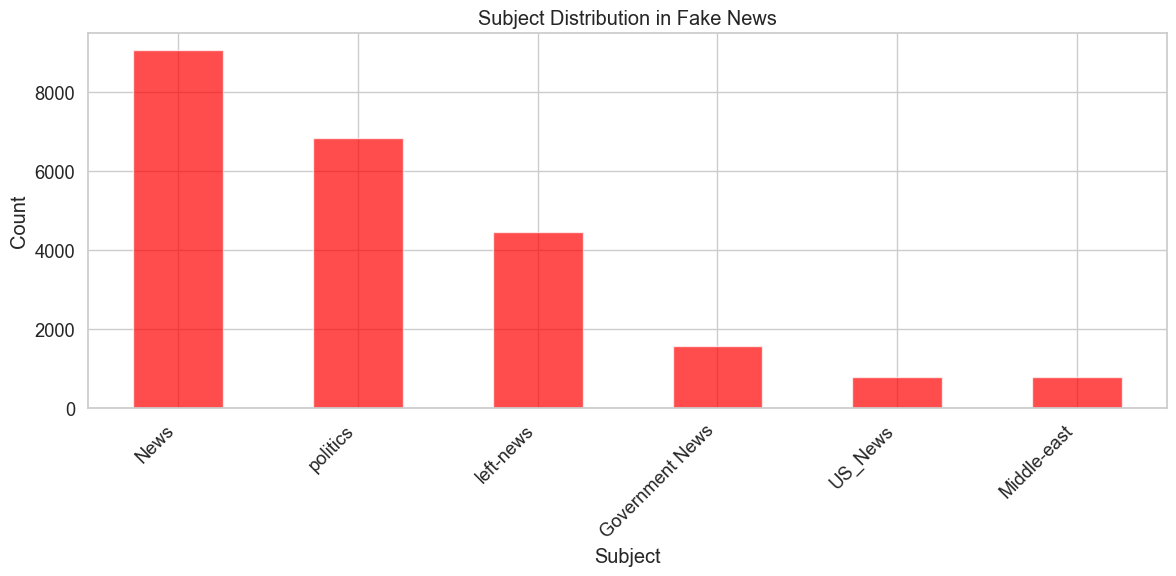

In [15]:
# Analyze subject distribution
plt.figure(figsize=(12, 6))
true_news['subject'].value_counts().plot(kind='bar', color='blue', alpha=0.7)
plt.title('Subject Distribution in Real News')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('./figures/real_news_subject_distribution.png')
plt.show()

plt.figure(figsize=(12, 6))
fake_news['subject'].value_counts().plot(kind='bar', color='red', alpha=0.7)
plt.title('Subject Distribution in Fake News')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('./figures/fake_news_subject_distribution.png')
plt.show()

This analysis shows the distribution of topics in each dataset, which can help identify potential topical biases. If certain subjects are exclusively or predominantly associated with one class, the model might learn to classify based on topic rather than veracity.

## 9. Temporal Analysis

I analyze the publication dates to identify any temporal patterns:

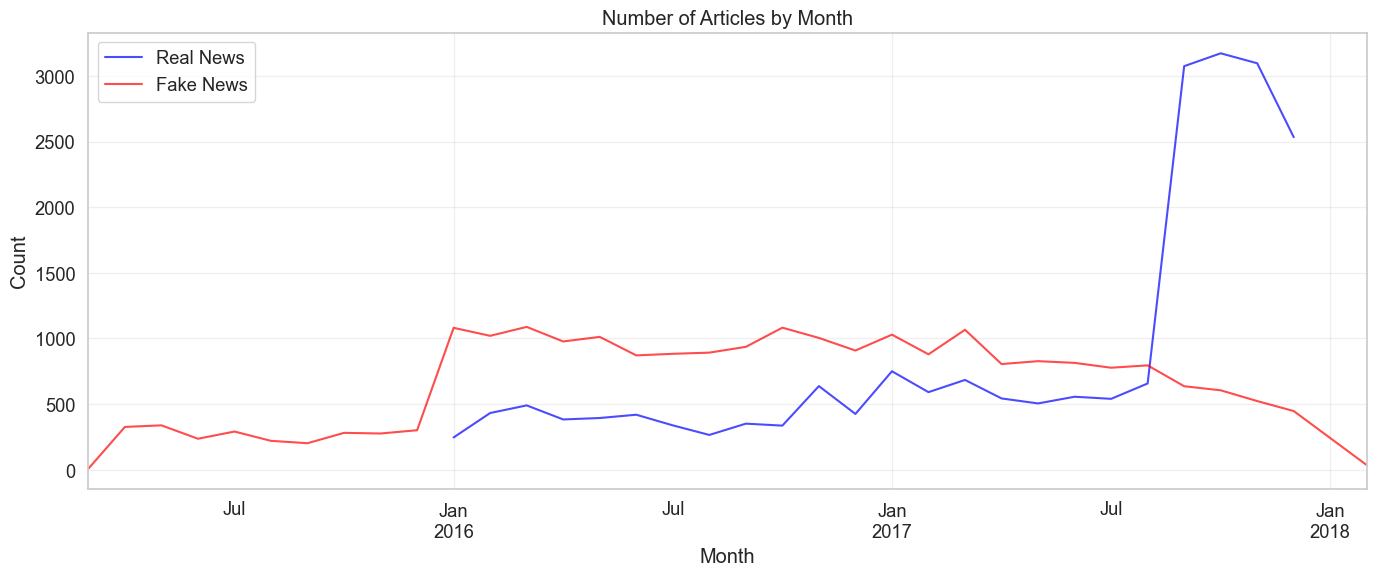

In [17]:
# Convert date strings to datetime objects with mixed format handling
true_news['date'] = pd.to_datetime(true_news['date'], errors='coerce')
fake_news['date'] = pd.to_datetime(fake_news['date'], format='mixed', errors='coerce')

# Extract month and year
true_news['month_year'] = true_news['date'].dt.to_period('M')
fake_news['month_year'] = fake_news['date'].dt.to_period('M')

# Count articles by month - handle potential NaT values
true_monthly = true_news.dropna(subset=['month_year'])['month_year'].value_counts().sort_index()
fake_monthly = fake_news.dropna(subset=['month_year'])['month_year'].value_counts().sort_index()

# Plot
plt.figure(figsize=(14, 6))
true_monthly.plot(label='Real News', color='blue', alpha=0.7)
fake_monthly.plot(label='Fake News', color='red', alpha=0.7)
plt.title('Number of Articles by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./figures/temporal_distribution.png')
plt.show()

This temporal analysis helps identify whether the real and fake news articles cover the same time periods. Significant differences in temporal distribution could lead to models that learn time-specific patterns rather than general indicators of fake news.

## 10. Conclusion and Next Steps

Based on this exploratory data analysis, I've identified several key insights and potential biases in the ISOT dataset:

1. **Source Markers**: The "(Reuters)" pattern appears in 99.21% of real news but only 0.04% of fake news, creating a strong potential for overfitting.

2. **Structural Patterns**: Real news articles follow journalistic conventions like location datelines, while fake news rarely does.

3. **Content Differences**: Real and fake news focus on different topics and use different language, which are legitimate signals for classification.

4. **Length Distribution**: Fake news shows higher variance in length, with more extreme outliers.

To address these issues, I'll implement the following preprocessing steps for model training:

1. Remove source markers like "(Reuters)" to prevent the model from relying on these shortcuts.

2. Consider removing location datelines or converting them to a more general format.

3. Implement robust cross-validation to ensure the model generalizes beyond the specific patterns in this dataset.

4. Create features that capture legitimate stylistic and content differences while avoiding dataset-specific artifacts.

These preprocessing steps will be implemented in the next notebook, where I'll prepare the data for model training.